# Answering Business Questions using SQL

The chinook SQLite sample database will be used for this project.

It's schema is as illustrated below:
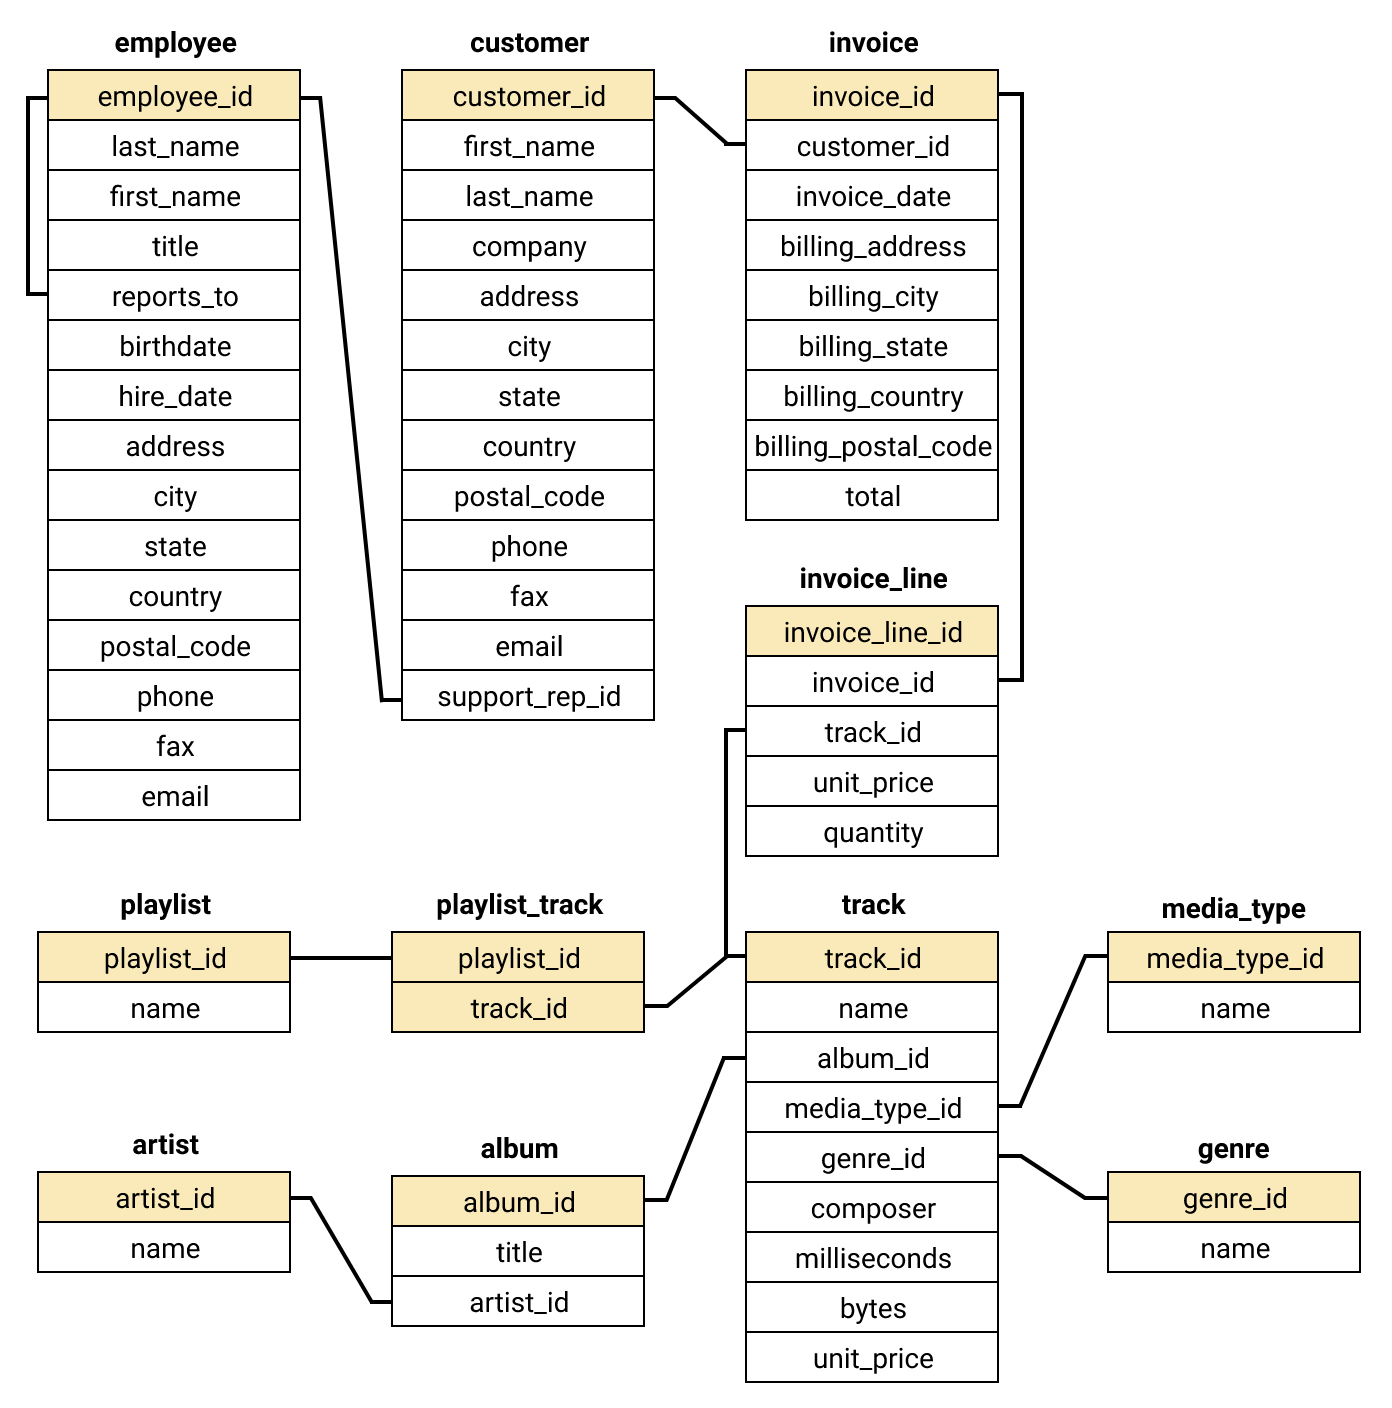

The tables in the database are:
- `employee` table: Stores employees data such as employee id, last name, first name, etc. It also has a field named reports_to to specify who reports to whom.
- `customer` table: Stores customers data.
- `invoice` & `invoice_line` tables: These two tables store invoice data. The invoice table stores invoice header data and the invoice_line table stores the invoice line items data.
- `artist` table: Stores artists data. It is a simple table that contains only the artist id and name.
- `album` table: Stores data about a list of tracks. Each album belongs to one artist. However, one artist may have multiple albums.
- `media_type` table: Stores media types such as MPEG audio and AAC audio files.
- `genre` table: Stores music types such as rock, jazz, metal, etc.
- `track` table: Stores the data of songs. Each track belongs to one album.
- `playlist` & `playlist_track` tables: Playlist table store data about playlists. Each playlist contains a list of tracks. Each track may belong to multiple playlists. The relationship between the playlist table and playlist_track table is many-to-many. The playlist_track table is used to reflect this relationship.

## Import Libraries

The libraries used in the project are:
- `pandas`: It offers data structures and operations for manipulating numerical tables and time series.
- `sqlite3`: It provides an SQL interface to work with SQLite database.
- `src`: It contains all python code written to successfully execute this project.

In [1]:
import sqlite3
import src.functions as fn

## Connect to Database

In [2]:
conn = sqlite3.connect('data/chinook.db')
print('Connection successful')

Connection successful


## Display Tables in the Database

In [3]:
# Query to get tables and views in the database
query = '''
SELECT name, type 
FROM sqlite_master 
WHERE type IN ("table","view");
'''
# Display the results in a list
fn.show_tables(query, conn)

['album',
 'artist',
 'customer',
 'employee',
 'genre',
 'invoice',
 'invoice_line',
 'media_type',
 'playlist',
 'playlist_track',
 'track']

## Case 1: Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you're in charge of choosing the first three albums to be added to the store. There are four albums to choose from, and all four are by artists who don't have any tracks in the store right now. Below is the list of artist names and the genre of music they produce:

|Artist Name |	Genre |
| --- | --- |
| Regal	| Hip-Hop |
| Red Tone	| Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA. To aid in selecting albums, we're interested in finding out which genres sell the best in the USA.

### 1.1 Commentary

In order to find the genres that sell best in the USA, we need to link genres to billing_country in the invoice table. We will then count the sales occurence of each genre in the USA. The output will be ranked in a descending order and the top 3 genres that match the genres of the new albums will be selected.

### 1.2 Genres Sold in the USA

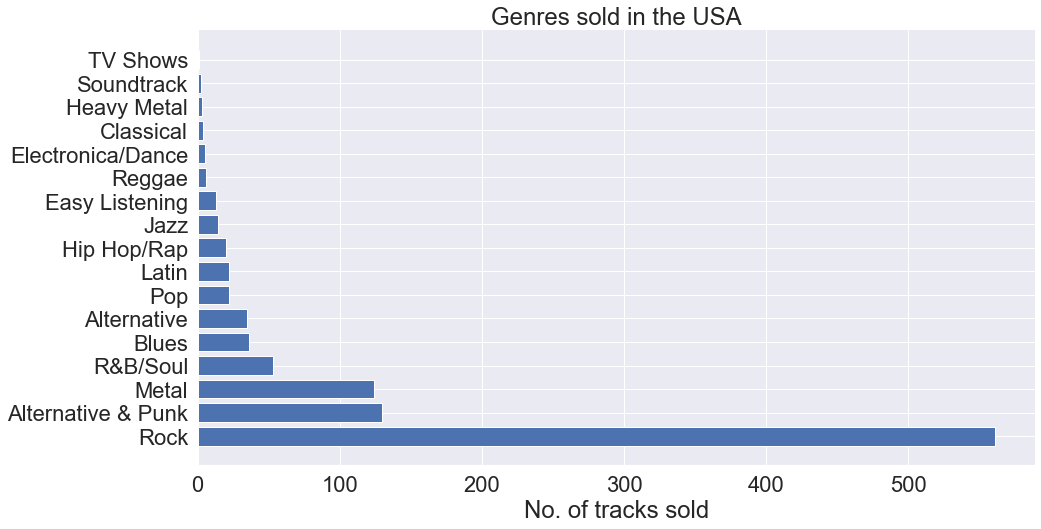

In [4]:
# Query to get genres sold in the USA
query = '''
WITH track_genre_cte AS
(
    SELECT t.name AS track_name, g.name AS genre_name
    FROM track AS t
    INNER JOIN genre AS g
    ON t.genre_id = g.genre_id
    INNER JOIN invoice_line AS il
    ON il.track_id = t.track_id
    INNER JOIN invoice AS i
    ON i.invoice_id = il.invoice_id
    WHERE billing_country = 'USA'
)

SELECT genre_name, COUNT(track_name) AS tracks
FROM track_genre_cte
GROUP BY genre_name
ORDER BY tracks DESC

'''

# Store results in a dataframe
df = fn.run_query(query, conn)

# Visualize the results
fn.horizontal_barplot(df.genre_name, df.tracks, 'Genres sold in the USA', 'No. of tracks sold')

From the above plot, `Rock` is the most popular genre in the USA. `Alternative & Punk` is the second most popular genre, followed closely by `Metal`. 

The other fairly popular genres are `R&B / Soul`, `Blues`, and `Alternative`, in descending order.

### 1.3 Albums to Advertise

Following the analysis above, the 3 albums to be advertised belong to the artists:
- Red Tone _(punk)_
- Slim Jim Bites _(Blues)_
- Meteor and the Girls _(Pop)_

## Case 2: Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

### 2.1 Commentary

To understand the performance of each sales support agent, we will investigate the sales associated over the available time period, that is, the invoice_date and total. We will also investigate if the hire_date has any effect on the performance, as well as the number of customers assigned to each agent. 

### 2.2 Yearly Sales per Agent

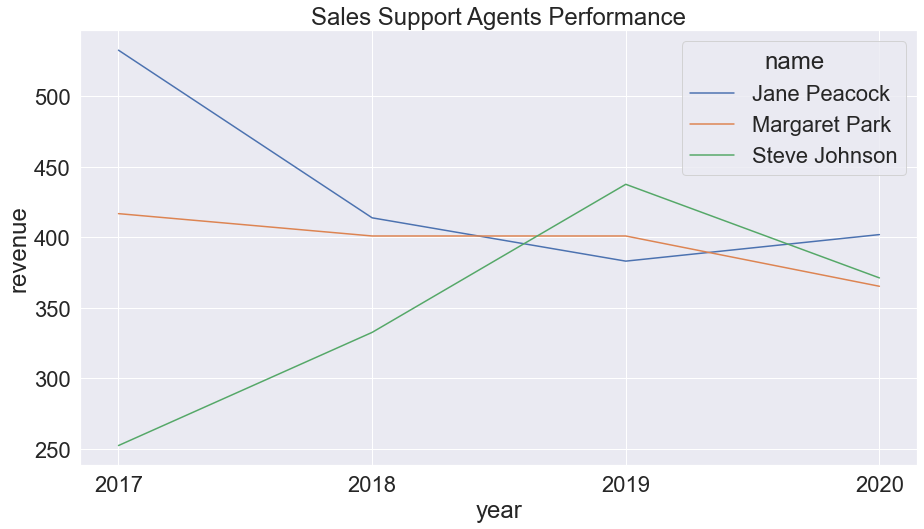

In [10]:
# Query to get monthly sales per agent
query = '''
SELECT e.first_name|| ' '|| e.last_name AS name, SUBSTRING(invoice_date,1, 4) AS year, SUM(total) AS revenue
FROM employee AS e
INNER JOIN customer AS c
ON e.employee_id = c.support_rep_id
INNER JOIN invoice AS i
ON i.customer_id = c.customer_id
GROUP BY name, year
'''

# Store the results in a dataframe
df = fn.run_query(query, conn)

# Visualize the results
fn.lineplot(df.year, df.revenue, df.name, 'Sales Support Agents Performance')

## Credits

The cases explored were obtained from [Dataquest](https://app.dataquest.io/m/374/guided-project%3A-answering-business-questions-using-sql/1/introduction-and-schema-diagram).